# PyTorch First Attempt

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable scrollable cells

<IPython.core.display.Javascript object>

In [2]:
! git clone https://github.com/samryan18/chess-ray-vision
! mv chess-ray-vision/clean_notebooks/* .
# !mkdir chess
# !mv chess-ray-vision/* chess

fatal: destination path 'chess-ray-vision' already exists and is not an empty directory.
mv: cannot stat 'chess-ray-vision/clean_notebooks/*': No such file or directory


# Setup Stuff

In [0]:
# ## Required packages
# !pip install tensorflow
# !pip install scipy
# !pip install numpy
# !pip install Pillow
# !pip install image

# ## Add any other packages you may need below

In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
  
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
import torchvision
import torch 
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import time, datetime
from pytorch_general.pytorch_helper import imshow
from pytorch_general.tensorboard_helper import Logger


from typing import Callable
import torch
import dill
import torch.optim as optim
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
import numpy as np
import re
piece_symbols = 'prbnkqPRBNKQ'

def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [0]:
# LOG_DIR = './logs'
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

# !if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

# get_ipython().system_raw('./ngrok http 6006 &')

# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

In [0]:
# https://www.kaggle.com/meditech101/chess-fen-generator-improved

In [0]:
# root_dir = "DATASETS"

# # input_size = 256
# # input_transforms = transforms.Compose([
# #             transforms.RandomResizedCrop(input_size, ratio=(1, 1.3)),
# #             transforms.ToTensor()])

# input_size = 224
# input_transforms = transforms.Compose([
#             transforms.Resize((input_size, input_size)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# train_dataset = dogs(root_dir, train=True, subset=3, 
#                      transform=input_transforms)
# test_dataset = dogs(root_dir, train=False, subset=3, 
#                     transform=input_transforms)

# # train_dataset = dogs(root_dir, train=True, subset=3, 
# #                      transform=transforms.ToTensor())
# # test_dataset = dogs(root_dir, train=False, subset=3, 
# #                     transform=transforms.ToTensor())

# batch_size = 50
# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True);

# test_loader = DataLoader(dataset=test_dataset,
#                          batch_size=batch_size,
#                          shuffle=True);

# print(f'train_images size: {len(train_loader)*batch_size}')
# print(f'test_images size: {len(test_loader)*batch_size}')

# for i in range(5):
#     image, label = next(iter(train_loader))
#     imshow(image[0,:]);
# # 2560 = max

In [0]:
from PIL import Image
from pathlib import Path


def load_datasets(directory='images/'):
    pathlist = Path(directory).glob('**/*.jpeg')
    labels = []
    images = []
    for path in pathlist:
        label = str(path).split(directory)[1].split(f'.')[0]
        label = onehot_from_fen(label)

        img = np.asarray(Image.open(str(path))).astype('uint8')
        labels.append(label)
        images.append(img)
        
    test_images, test_labels = (images, labels) # TODO
        
    return images, labels, test_images, test_labels
images, labels, test_images, test_labels = load_datasets()

In [0]:
from PIL import Image
from torch.autograd import Variable


class CustomChessDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, transform=None, train=True):
        train_images, train_labels, test_images, test_labels = load_datasets()
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        if train:
            self.images = train_images
            self.labels = np.asarray(train_labels)
            
        else:
            self.images = test_images
            self.labels = np.asarray(test_labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        i = self.images[idx]
        img_as_img = Image.fromarray(i)
        img_as_img = img_as_img.convert('L')

        return (self.to_tensor(img_as_img), 
                self.labels[idx])


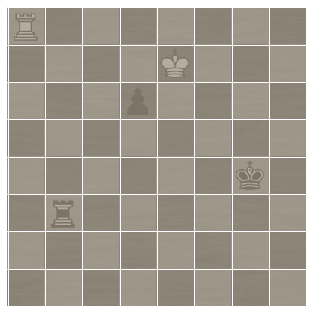

In [12]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CustomChessDataset(train=True, transform=transform)
test_dataset = CustomChessDataset(train=False, transform =transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)

image, label = next(iter(test_loader))
imshow(image[0,:]);

In [0]:
def train_model(model: nn.Module, 
                log_dir: str,
                train_loader,
                criterion,
                optimizer,
                num_epochs,
               log_freq) -> nn.Module:
    t = datetime.datetime.now()
    now = time.mktime(t.timetuple()) - 1550000000
    logger = Logger(f'{log_dir} ({now})/')
    
    print(now)

    model = model.to(device)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0
        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.long().to(device)

            output = model(images).to(device)
            print(np.shape(labels))
            print(np.shape(output))
            loss = criterion(output, labels).to(device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, argmax = torch.max(output, 1)
            accuracy = (labels == argmax.squeeze()).float().mean()

            running_loss += loss.item()

            if step % log_freq == 0:

                overall_step = epoch*total_step + step

                # 1. Log scalar values (scalar summary)
                info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

                for key, value in info.items():
                    logger.scalar_summary(key, value, overall_step)

                # 2. Log values and gradients of the parameters (histogram summary)
                for key, value in model.named_parameters():
                    key = key.replace('.', '/')
                    logger.histo_summary(key, value.data.cpu().numpy(), overall_step)
                    try:
                        logger.histo_summary(key+'/grad', value.grad.data.cpu().numpy(), overall_step)
                    except (AttributeError):
                        # During transfer learning some of the variables don't have grads
                        pass
                        

        print(f"{epoch}: Training loss: {running_loss/len(train_loader)}")
        print(f"{epoch}: Training accuracy: {accuracy}")
 
    return model


def test_model(model, criterion, test_loader) -> float:
    model = model.to(device)
    correct = 0
    total = 0
    accuracies = []
    losses = []
    total_step = len(test_loader)
    with torch.no_grad():
        for i in range(total_step):
            for  images, labels in test_loader:
                images, labels = images.to(device), labels.long().to(device)

                output = model(images)
                loss = criterion(output, labels)
                losses.append(loss.item())


                # Compute accuracy
                _, argmax = torch.max(output, 1)
                accuracy = (labels == argmax.squeeze()).float().mean()
                accuracies.append(accuracy)
                
                

    print(f'Accuracy of the network on test images: {np.average(accuracy.cpu())}')
    print(f'Avg. Loss of the network on test images: {np.average(losses)}')

    return np.average(accuracy.cpu())

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(400*400*1, 64*52),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(64*52, 64*52),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(64*52, 64*52),
            nn.ReLU())
        self.fc4 = nn.Sequential(
            nn.Linear(64*52, 64*26),
            nn.ReLU())
        self.fc5 = nn.Sequential(
            nn.Linear(64*26, 64*13),
            nn.ReLU())
        self.fc6 = nn.Sequential(
            nn.Linear(64*13, 64*13),
            nn.ReLU())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = out.reshape(1, 64, 13)
        out = F.log_softmax(out, dim=2)

#         out = F.log_softmax(self.fc6(out.reshape(1, 64, 13)), dim=1)

        return out
    
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         self.conv1 = nn.Conv2d(3, 32, 4)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout(p = 0.1)

#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.dropout2 = nn.Dropout(p = 0.2)

#         self.conv3 = nn.Conv2d(64, 128, 2)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.dropout3 = nn.Dropout(p = 0.3)

#         self.conv4 = nn.Conv2d(128, 256, 3)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.pool4 = nn.MaxPool2d(2, 2)
#         self.dropout4 = nn.Dropout(p = 0.4)

#         self.fc1 = nn.Linear(256*12*12, 1000)
#         self.dropout5 = nn.Dropout(p = 0.5)
#         self.fc2 = nn.Linear(1000, 1000)
#         self.dropout6 = nn.Dropout(p = 0.6)
#         self.fc3 = nn.Linear(1000, 250)
#         self.dropout7 = nn.Dropout(p = 0.7)
#         self.fc4 = nn.Linear(250, 120)


#     def forward(self, x):
#         x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
#         x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
#         x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
#         x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))
#         x = x.view(x.size(0), -1)
#         x = self.dropout5(self.fc1(x))
#         x = self.dropout6(self.fc2(x))
#         x = self.dropout7(self.fc3(x))
#         x = self.fc4(x)
#         x = F.log_softmax(x, dim=1)
#         return x



In [0]:
def multi_class_cross_entropy_loss_torch(predictions, labels):
    """
    Calculate multi-class cross entropy loss for every pixel in an image, for every image in a batch.

    In the implementation,
    - the first sum is over all classes,
    - the second sum is over all rows of the image,
    - the third sum is over all columns of the image
    - the last mean is over the batch of images.
    
    :param predictions: Output prediction of the neural network.
    :param labels: Correct labels.
    :return: Computed multi-class cross entropy loss.
    """
    labels = labels.float()
    log_predictions = torch.log(predictions)
    print(log_predictions)
    xxx = torch.sum(labels * log_predictions, dim=1)
    print(xxx)
    xxxx = torch.sum(xxx, dim=1)
    loss = -torch.mean(xxxx)

#     loss = -torch.mean(torch.sum(xxxx, dim=1))
    return loss

In [16]:
num_epochs = 1
batch_size = 1
learning_rate = 0.0028
log_freq=25
net = Net()
      
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

log_dir = f'./logs/PRELIM_lr{learning_rate}'
criterion = nn.CrossEntropyLoss().to(device)
criterion = multi_class_cross_entropy_loss_torch
    
model = train_model(net,
                log_dir,
                train_loader,
                criterion,
                optimizer,
                num_epochs, log_freq)

final_acc = test_model(model, criterion, test_loader)



4086782.0
torch.Size([1, 64, 13])
torch.Size([1, 64, 13])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0', grad_fn=<SumBackward2>)
0: Training loss: nan
0: Training accuracy: 0.006009615492075682
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0')
Accuracy of the network on test images: 0.007211538963019848
Avg. Loss of the network on test images: nan


In [0]:
onehot_from_fen('4kN1N-B1P5-QQ3B2-R1n1b3-8-1p2P3-1K6-6b1')

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 

In [0]:
! pip install Image

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


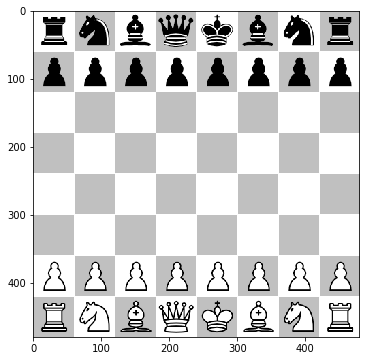

In [0]:
%matplotlib inline

# from matplotlib.pyplot import imshow
# import matplotlib.pyplot as plt
from draw_chess_boards import *

renderer = DrawChessPosition(delimiter='-')
fen = "r2q1rk1/pp2ppbp/1np2np1/2Q3B1/3PP1b1/2N2N2/PP3PPP/3RKB1R"
fen = "rnbqkbnr-pppppppp-8-8-8-8-PPPPPPPP-RNBQKBNR"
board = renderer.draw(fen)
renderer.show(board)

In [0]:
def train(model, optimizer, loss_fn, dataloader, metrics, params):
    """Train the model on `num_steps` batches

    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    loss_avg = RunningAverage()

    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params.cuda:
                train_batch, labels_batch = train_batch.cuda(async=True), labels_batch.cuda(async=True)
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output and loss
            output_batch = model(train_batch)
            #logger.debug("train output_batch.shape = {}. labels_batch.shape = {}".format(output_batch.shape, labels_batch.shape))

            # check if predictions are negative
            logger.info("negative predictions: {}".format((output_batch < 0.0).any()))

            # compute loss
            loss = loss_fn(output_batch, labels_batch)
            logger.debug("loss: {}".format(loss.data.item()))

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            # Evaluate summaries only once in a while
            if i % params.save_summary_steps == 0:
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.cpu().numpy()
                labels_batch = labels_batch.data.cpu().numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                summary_batch['loss'] = loss.data.item()
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.data.item())

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logger.info("- Train metrics: " + metrics_string)


def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file=None):
    """Train the model and evaluate every epoch.

    Args:
        model: (torch.nn.Module) the neural network
        train_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        val_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches validation data
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) optional- name of file to restore from (without its extension .pth.tar)
    """

    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(model_dir, restore_file + '.pth.tar')
        logger.info("Restoring parameters from {}".format(restore_path))
        load_checkpoint(restore_path, model, optimizer)

    best_val_acc = 0.0

    for epoch in range(params.num_epochs):
        # Run one epoch
        logger.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        train(model, optimizer, loss_fn, train_dataloader, metrics=metrics, params=params)

        # Evaluate for one epoch on validation set
        val_metrics = evaluate(model, loss_fn, val_dataloader, metrics=metrics, params=params)

        # TODO: Fix TypeError: 'NoneType' object is not subscriptable
        val_acc = val_metrics['accuracy']
        is_best = val_acc>=best_val_acc

        # Save weights
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                          is_best=is_best,
                          checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
            logger.info("- Found new best accuracy")
            best_val_acc = val_acc

            # Save best val metrics in a json file in the model directory
            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        save_dict_to_json(val_metrics, last_json_path)

def main():
    # print some log messages
    logger.info("DSTL Satellite Imagery Feature Detection - Train U-Net Model")

    # load parameters
    # load parameters from configuration file
    params = Params('experiment/unet_model/params_3ch.yaml', ParameterFileType.YAML, ctx=None)

    # parameters
    logger.debug("parameters: \n{}\n".format(pformat(params.dict)))

    # use GPU if available
    params.cuda = torch.cuda.is_available()

    # Set the random seed for reproducible experiments
    torch.manual_seed(230)
    if params.cuda:
        torch.cuda.manual_seed(230)

    # dataset parameters, which includes download, input, output and mask generation parameters.
    dataset_params = params.dataset
    logger.debug("dataset parameters: \n{}\n".format(pformat(dataset_params)))

    # dataset
    logger.info("loading datasets...")
    train_set = DSTLSIFDDataset(dataset_params=dataset_params,
                                mode='train',
                                transform=True,
                                transform_mask=None,
                                download=False)

    dev_set   = DSTLSIFDDataset(dataset_params=dataset_params,
                                mode='dev',
                                transform=True,
                                transform_mask=None,
                                download=False)

    # dataloader
    logger.debug("train dataloader, batch size: {}, num workers: {}, cuda: {}".format(
        params.train['batch_size'],
        params.train['num_workers'],
        params.cuda));

    train_dl = DataLoader(dataset=train_set,
                          batch_size=params.train['batch_size'],
                          shuffle=True,
                          num_workers=params.train['num_workers'],
                          pin_memory=params.cuda)

    logger.debug("dev dataloader, batch size: {}, num workers: {}, cuda: {}".format(
        params.valid['batch_size'],
        params.valid['num_workers'],
        params.cuda));

    valid_dl = DataLoader(dataset=dev_set,
                          batch_size=params.valid['batch_size'],
                          shuffle=True,
                          num_workers=params.valid['num_workers'],
                          pin_memory=params.cuda)

    logger.info("- done.")

    # define the model and optimizer
    #model = UNet()
    model = UNet().cuda() if params.cuda else UNet()
    logger.info("using adam optimized with lr = {}".format(float(params.learning_rate)))
    optimizer = optim.Adam(model.parameters(), lr=float(params.learning_rate))

    # loss function
    loss_fn = multi_class_cross_entropy_loss  # nn.MSELoss()  # nn.L1Loss() # nn.CrossEntropyLoss()

    # maintain all metrics required in this dictionary- these are used in the training and evaluation loops
    metrics = {
        'accuracy': accuracy,
        # could add more metrics such as accuracy for each token type
    }

    # train the model
    logger.info("Starting training for {} epoch(s)".format(params.num_epochs))

    data_dir = "data/"
    model_dir = "experiment/unet_model"

    train_and_evaluate(model=model,
                       train_dataloader=train_dl,
                       val_dataloader=valid_dl,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       metrics=metrics,
                       params=params,
                       model_dir=data_dir,
                       restore_file=None)


if __name__ == '__main__':
    main()